# Transfer Learning for Jet Tagging in Particle Physics: GNN

This is the second accompanying notebook for our final project for the CSCI 2470: Deep Learning course. Here, we will present appropriate visualizations of our input data, build and train our models, and present appropriate visualizations of the outputs and results.

*Authors: Jade Ducharme, Egor Serebriakov, Aditya Singh, Anthony Wong*

### Stage 2: Transfer Learning via GNN

The current state-of-the-art jet tagging model uses a Graph Neural Network architecture. Our second goal is then to build a Teacher and a Student GNN and implement transfer learning similarly to what we did with the FCCN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.optim as optim
from torch_geometric.loader import DataLoader
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import time
from preprocess import *
from helper import *

sns.set_theme()
plt.style.use("seaborn-v0_8")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Initialize some global hyperparameters

K = 16  # number of neighbors for the KNN
NE = 20  # number of epochs
LR = 3e-4  # learning rate
WEIGHT_DECAY = 1e-5  # weight decay for L2 regularization
BATCH_SZ = 384  # batch size
MAX_ITEMS = 120000  # maximum number of elements to consider (input size)
MAX_CONSTITS = 80  # maximum number of constituent elements per jet: 80
REDUCED_CONSTITS = 40  # number of constituent elements for the Student network to consider: 40
NOISE_STD = 5e3  # noise standard deviation for the diffusion

Similarly to the first notebook, we will start by loading in the data and preprocessing. Note that since we are now working with *graphs*, the preprocessing steps will differ significantly!

In [3]:
cons_data, cons_labels, cons_weights, cons_features = get_data(
    "./data/train.h5", 
    attribute="constituents",
    max_items=MAX_ITEMS,
)

print("---------- Constituent-level data ----------------", "\n")
print("Data shape [input_size, num_constituents, num_features]:", cons_data.shape, "\n")
print("Feature names:", cons_features)
print("Feature names (human-readable):", [human_feature(f) for f in cons_features])

---------- Constituent-level data ---------------- 

Data shape [input_size, num_constituents, num_features]: (120000, 200, 4) 

Feature names: ['fjet_clus_E' 'fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_pt']
Feature names (human-readable): ['constituent energy', 'constituent pseudo-rapidity', 'constituent azimuthal angle', 'constituent transverse momentum']


We will preprocess this using the same steps as for the FCNN

In [4]:
pre_cons_data, pre_cons_features = constituent_preprocess(cons_data, cons_features, max_constits=MAX_CONSTITS)

print("Preprocessed constituent data shape:", pre_cons_data.shape)
print("Preprocessed features:", pre_cons_features)

Preprocessed constituent data shape: (120000, 80, 7)
Preprocessed features: ['delta_eta' 'delta_phi' 'log_pt' 'log_E' 'lognorm_pt' 'lognorm_E' 'R']


To implement our GNN, we then need to form graphs using our data. We will do so using the k-nearest-neighbors algorithm, and we will try to run on GPU to accelerate the graph making process.

In [5]:
from preprocess import prepare_graphs

# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

graphs = prepare_graphs(pre_cons_data, cons_labels, k=K, weights=cons_weights, device=device, batch_size=BATCH_SZ)

Device: cuda


100%|██████████| 313/313 [01:26<00:00,  3.62it/s]


#### Visualize

We can visualize the graphs we just created!

In [6]:
from visualize import visualize_graph

# visualize_graph(graphs[100], x_axis='fjet_clus_phi', y_axis='fjet_clus_eta')

#### Build the Teacher GNN

Let's build the Teacher GNN and train it on the high-resolution data:

In [7]:
from model import JetGNN
from preprocess import split_graphs
from model import run_gnn

# prepare data
train_dataset, val_dataset, test_dataset = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SZ, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SZ, shuffle=True)

# initialize model
teacher_gnn = JetGNN().to(device)
optimizer = optim.AdamW(teacher_gnn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

# start training
t0 = time.time()
for e in range(1,NE+1):

    # training
    loss, acc = run_gnn(teacher_gnn, device, train_loader, criterion, optimizer, train=True)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = run_gnn(teacher_gnn, device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    if e%5 == 0:
        print(f"E {e:02d} -- Train loss: {loss:.4f} -- Train acc: {acc:.4f} -- "\
                + f"Val loss: {val_loss:.4f} -- Val acc: {val_acc:.4f} -- "\
              + f"t elapsed: {time_elapsed(t0, time.time())} min"
    )

E 05 -- Train loss: 0.3506 -- Train acc: 0.8484 -- Val loss: 0.3732 -- Val acc: 0.8347 -- t elapsed: 3.51 min
E 10 -- Train loss: 0.3266 -- Train acc: 0.8615 -- Val loss: 0.3619 -- Val acc: 0.8389 -- t elapsed: 7.03 min
E 15 -- Train loss: 0.3103 -- Train acc: 0.8683 -- Val loss: 0.3254 -- Val acc: 0.8535 -- t elapsed: 10.55 min
E 20 -- Train loss: 0.2946 -- Train acc: 0.8745 -- Val loss: 0.3256 -- Val acc: 0.8581 -- t elapsed: 14.07 min


In [8]:
# Testing on unseen data...
test_loss, test_acc = run_gnn(teacher_gnn, device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.3402	 Final test acc: 0.8552


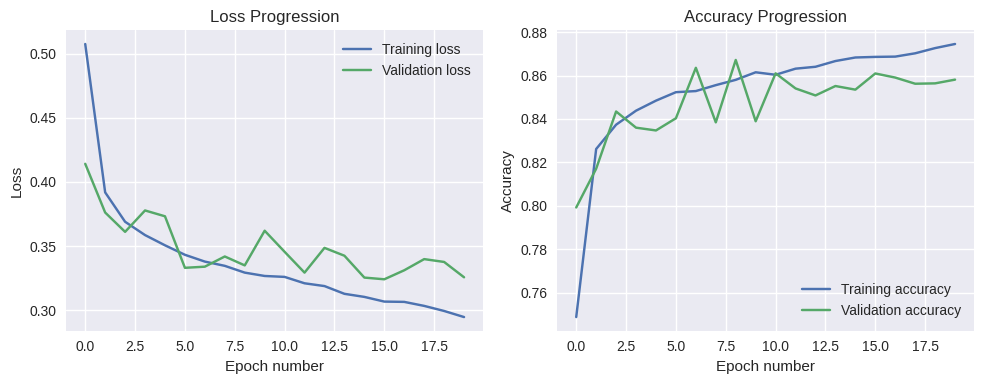

In [9]:
from visualize import plot_loss_and_accuracy

plot_loss_and_accuracy(loss_list, val_loss_list, acc_list, val_acc_list)

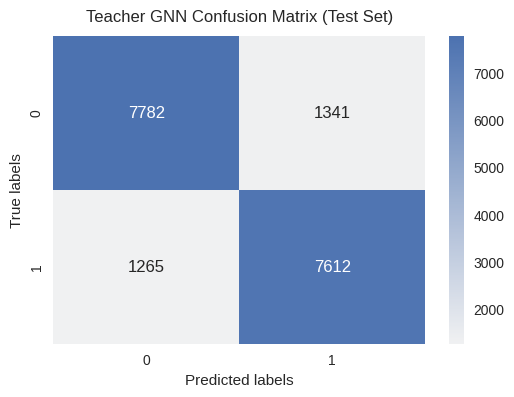

In [10]:
from visualize import plot_confusion_matrices

true = []
pred = []
for d in test_dataset:
    l = d.y.item()
    true.append(int(l))
    p = np.argmax(teacher_gnn(d.to(device)).cpu().detach().numpy())
    pred.append(p)

plot_confusion_matrices(true, pred, "Teacher GNN")

#### Diffusion

Next, we diffuse the input data along the energy column, padd back to the original number of constituents, and recreate the graphs

In [17]:
from helper import diffuse

diffused_cons_data = diffuse(cons_data, cons_features, noise_std=NOISE_STD, apply_features=['fjet_clus_E'])

diff_pre_cons_data, _ = constituent_preprocess(diffused_cons_data, cons_features, max_constits=REDUCED_CONSTITS)
padded_data = add_constits(diff_pre_cons_data, target_shape=MAX_CONSTITS)

graphs = prepare_graphs(padded_data, cons_labels, k=K, weights=cons_weights, device=device, batch_size=BATCH_SZ)

100%|██████████| 313/313 [01:23<00:00,  3.74it/s]


### Student model - no distillation

In [18]:
# prepare data
train_dataset, val_dataset, test_dataset = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SZ, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SZ, shuffle=True)

# initialize model
student_no_distill = JetGNN().to(device)
optimizer = optim.AdamW(student_no_distill.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

# start training
t0 = time.time()
for e in range(1,NE+1):

    # training
    loss, acc = run_gnn(student_no_distill, device, train_loader, criterion, optimizer, train=True)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = run_gnn(student_no_distill, device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    if e%5 == 0:
        print(f"E {e:02d} -- Train loss: {loss:.4f} -- Train acc: {acc:.4f} -- "\
                + f"Val loss: {val_loss:.4f} -- Val acc: {val_acc:.4f} -- "\
              + f"t elapsed: {time_elapsed(t0, time.time())} min"
    )

E 05 -- Train loss: 0.3536 -- Train acc: 0.8464 -- Val loss: 0.3595 -- Val acc: 0.8407 -- t elapsed: 3.59 min


KeyboardInterrupt: 

In [ ]:
# Testing on unseen data...
test_loss, test_acc = run_gnn(student_no_distill, device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

In [ ]:
plot_loss_and_accuracy(loss_list, val_loss_list, acc_list, val_acc_list)

### Transfer Learning from the Teacher to the Student GNN

In [ ]:
from model import train_gnn_with_distillation

# initialize model
student_gnn = JetGNN().to(device)
optimizer = optim.AdamW(student_gnn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

# start training
t0 = time.time()
for e in range(1,NE+1):

    # training
    loss, acc = train_gnn_with_distillation(student_gnn, teacher_gnn, 
                                             train_loader, criterion, optimizer, 
                                             device, alpha=0.5, temperature=2.0)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = run_gnn(student_gnn, device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    if e%5 == 0:
        print(f"E {e:02d} -- Train loss: {loss:.4f} -- Train acc: {acc:.4f} -- "\
                + f"Val loss: {val_loss:.4f} -- Val acc: {val_acc:.4f} -- "\
              + f"t elapsed: {time_elapsed(t0, time.time())} min"
    )

In [ ]:
# Testing on unseen data...
test_loss, test_acc = run_gnn(student_gnn, device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

In [ ]:
# Check out what hardware we're running on
!nvidia-smi

In [ ]:
# Note: good performance and speed with NVIDIA TITAN RTX